# Main Code to be used for processing

In [5]:
import json

from utils.helpers import extractRoutesArray
from utils.helpers import extractOuterWalls
from utils.helpers import createNewPathWithCoordinate
from utils.helpers import gettingTenantWalls
from utils.helpers import plotNumpyArrayOverImage
from utils.helpers import breakThroughWalls
from utils.helpers import convertSkeletonToLines

from utils.helpers import base64ToImage
from utils.helpers import plotNodesOverImage
from utils.helpers import plotLinesOverImage
from utils.helpers import plotPOIOverImage
from utils.helpers import draw_lines_on_image

from utils.shapeExport import save_stair_shapefile, save_path_segments_shapefile

Visualizing floor 1


/Users/huiningonn/Documents/systems/SyDS/syds_backend/pythons/utils/helpers.py:19: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  pruned = remove_small_objects(labeled, min_size=50)


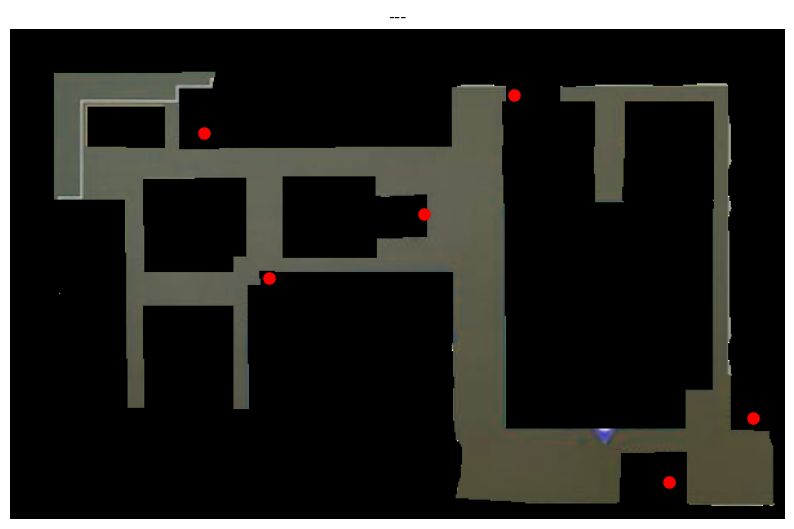

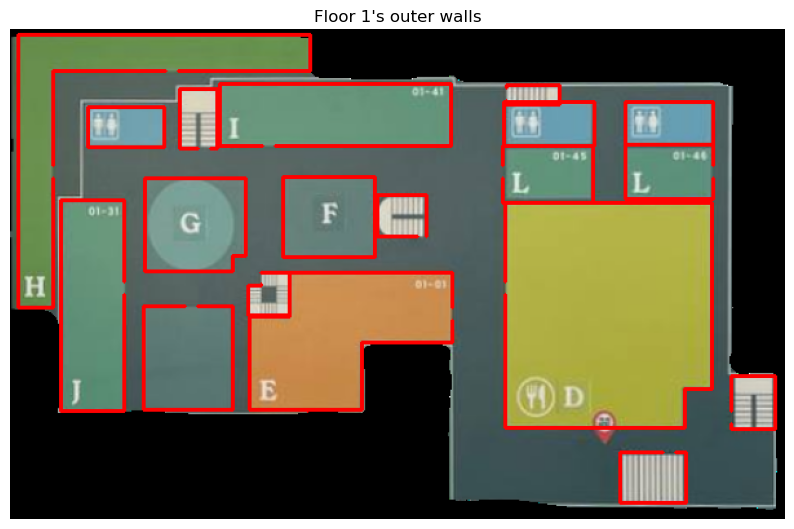

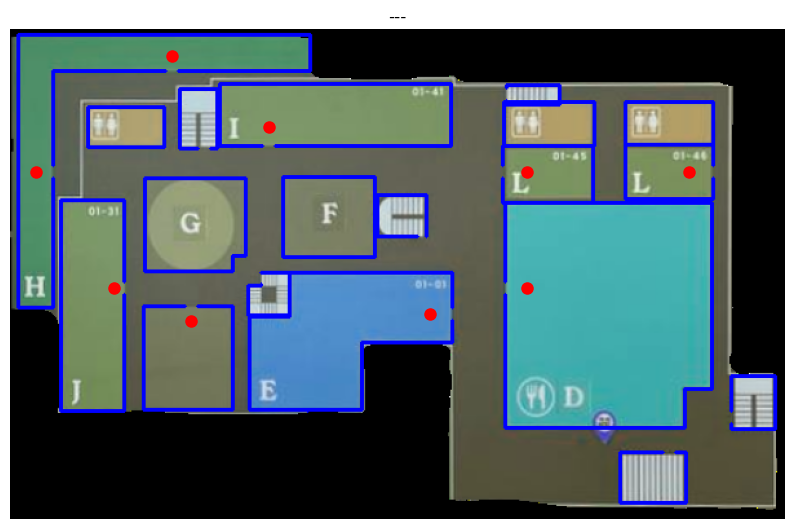

Visualizing floor 2


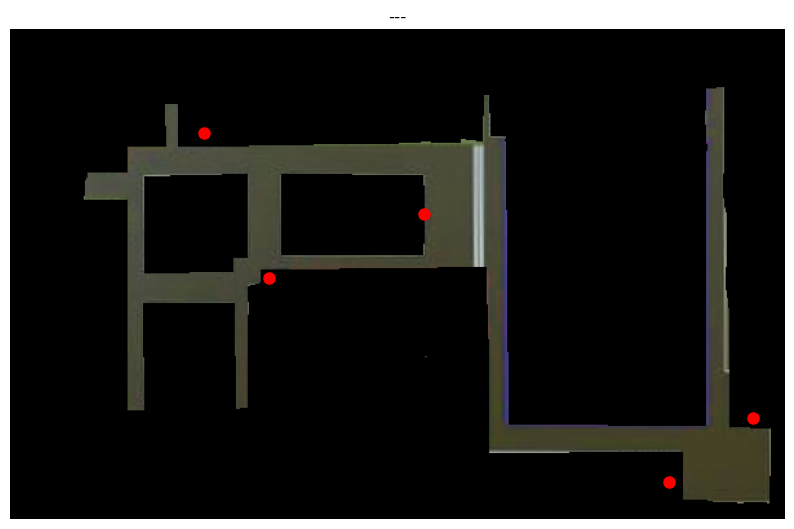

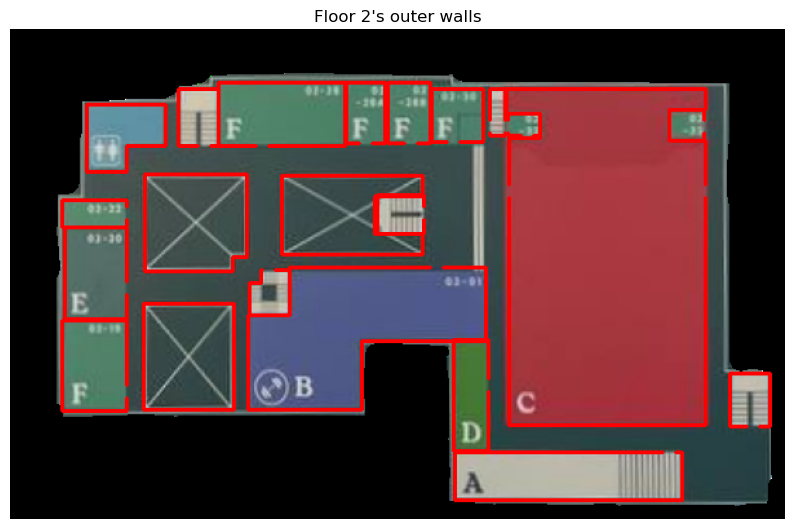

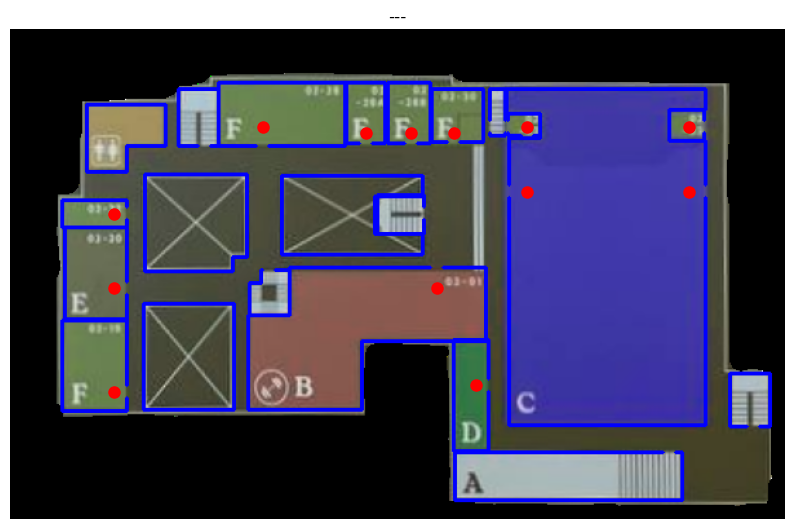

Visualizing floor 3


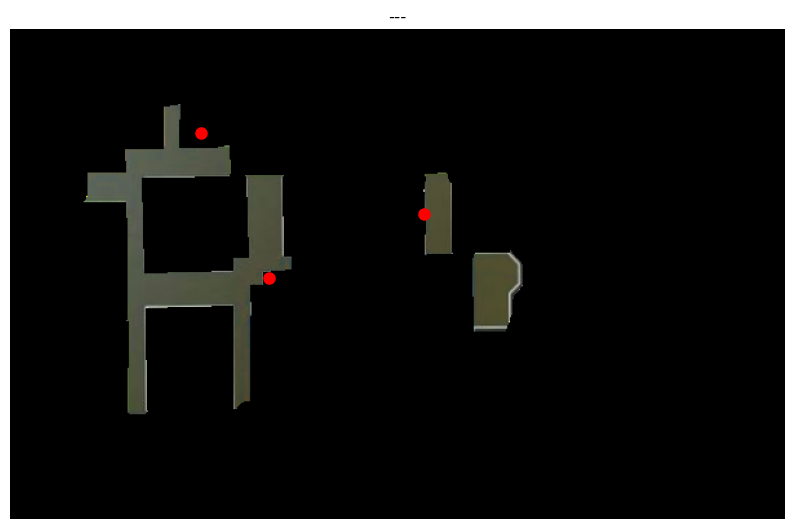

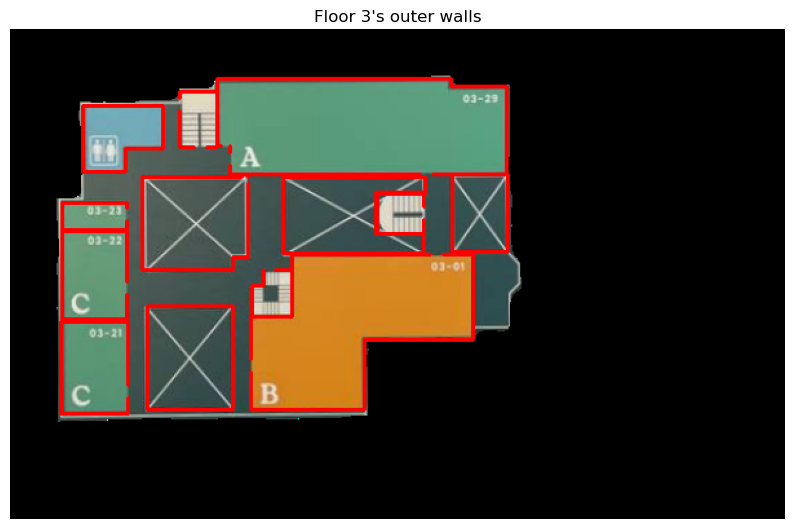

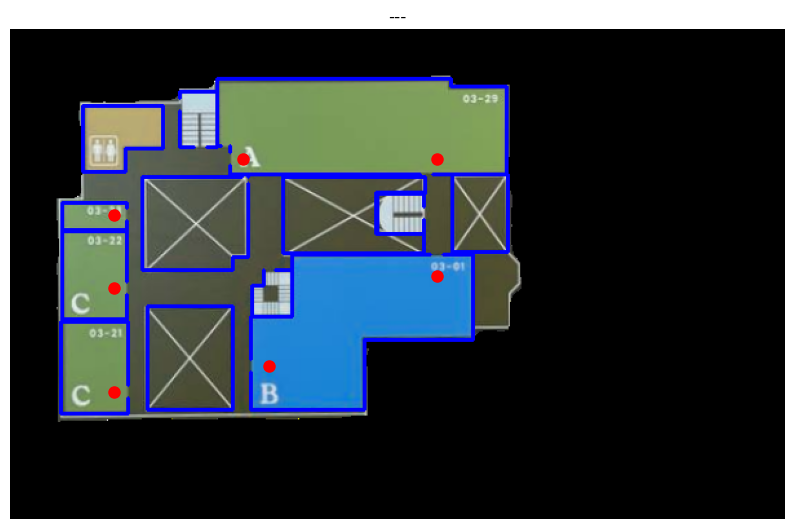

Visualizing floor 4


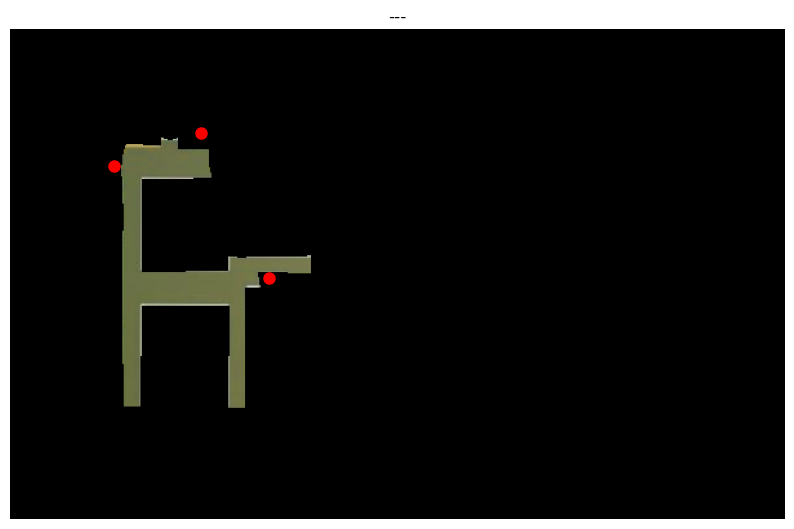

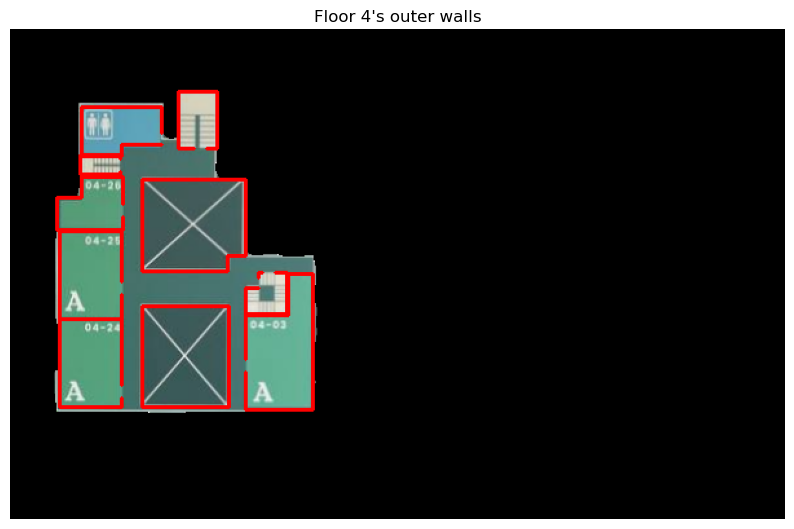

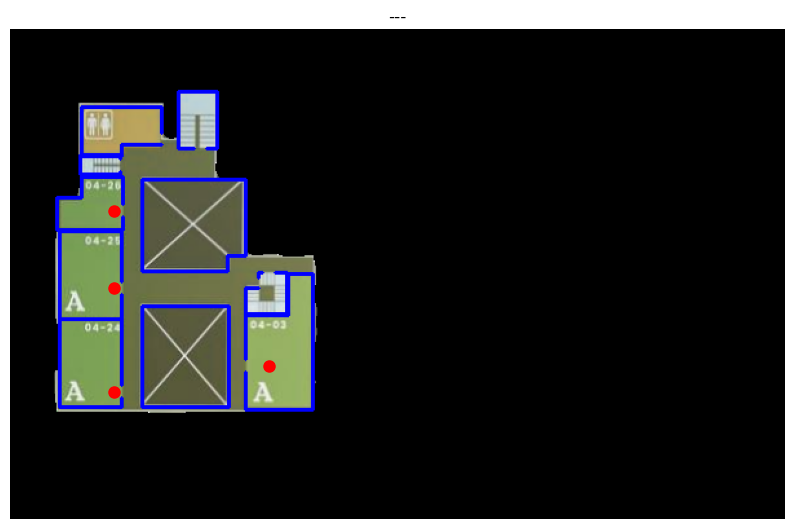

Visualizing floor 5


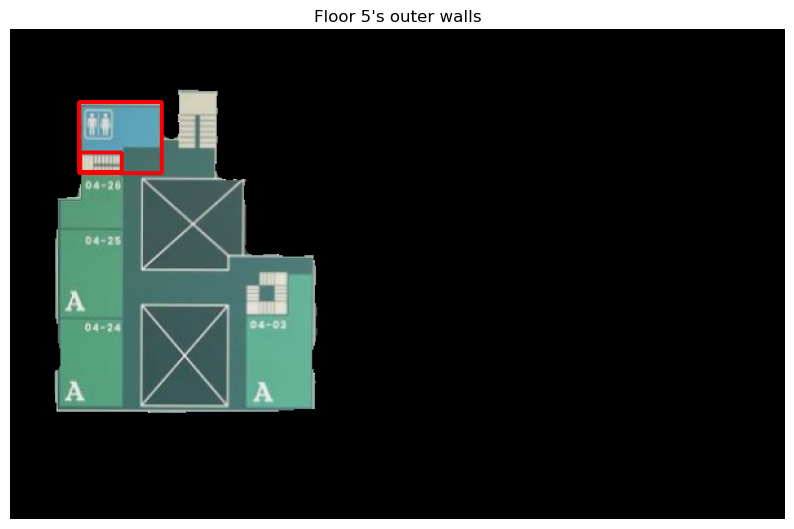

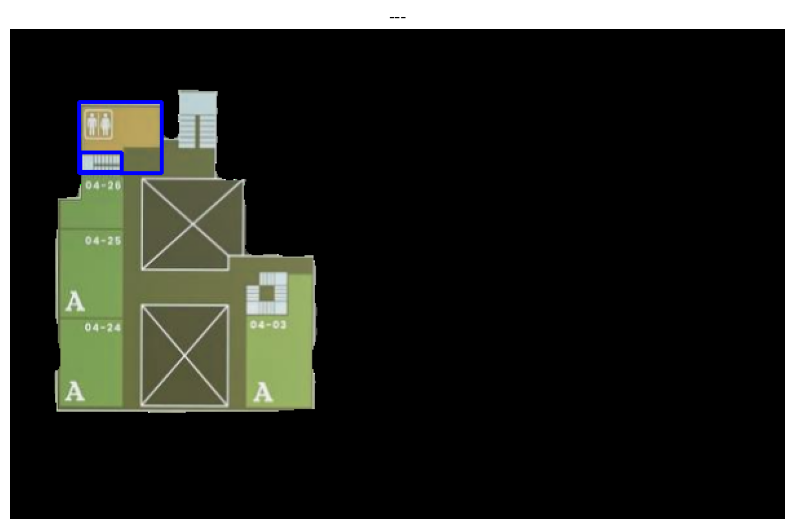

In [6]:
with open("data.json") as f:
    """
    We output the following

    outerWalls: {floor: [(x, y), (x, y), (x, y), ...], ...}
    bins: {floor: [(x, y), (x, y), (x, y), ...], ..., floorN: None} None has been added for floors without bins\
    tenants: {floor: {POIIndex: [[(x, y), (x, y), ...], [(x, y), (x, y), ...], ...]}, ...}
    tenantsSkipper: {floor: {POIIndex: [[i, i, ...], [], ...]}, ...}
    agentPoints: {floor: [(x, y), (x, y), ...], ...}
    """
    data = json.load(f)
    allRegions = data.get("drawnRegions", {})
    shapes = data.get("shapeLabels", {})
    walkways = data.get("walkways", [])
    paddedImages = data.get("paddedImages", [])
    tenantNodes = {
        0: [(20, 110), (80, 200), (125, 20), (200, 75), (140, 225), (325, 220), (400, 110), (525, 110), (400, 200)], 
        1: [(80, 200), (80, 280), (80, 142), (195, 75), (310, 80), (275, 80), (343, 80), (330, 200), (360, 275), (400, 125), (400, 75), (525, 125),(525, 75)],
        2: [(80, 200), (80, 280), (80, 143), (180, 100), (330, 100), (330, 190), (200, 260)],
        3: [(80, 200), (80, 280), (80, 140), (200, 260)]
        }
    StairNodes = {
        0: [(150, 80), (320, 142), (200, 192),  (390, 50),  (575, 300), (510, 350)], 
        1: [(150, 80), (320, 142), (200, 192), (575, 300), (510, 350)],
        2: [(147, 80), (320, 142), (200, 192)],
        3: [ (80, 105), (147, 80), (200, 192)]
        }
    binLocations = {
        0: [(135, 95), (440, 350)],
        1: [(135, 95), (350, 142)],
        2: [(135, 95)],
        3: [(135, 95)]
    }

    # Dictionary of outputs
    paths = {}
    bins = {}
    agentPoints= tenantNodes
    ### Do note that I did not put a closing point so there is a line between the first and last node
    tenants = {}
    tenantsSkipper = {}
    ### This one has a closing point which is the same point as the starting node
    outerWalls = {}

    for index, base64Img in enumerate(walkways):
        # Outer Walls
        ### Getting the points of the outerwall
        floorOuterWalls = extractOuterWalls(paddedImages[index], 15, 5)

        # Routes
        ### Getting a first guess of the path using openCV
        ##### May need a way to simplofy this into a line #####
        floorSkeleton = extractRoutesArray(base64Img) 

        ### Adding additional line based on points of interest to the Routes
        floorTenantNodes = tenantNodes.get(index, [])
        for node in floorTenantNodes:
            floorSkeleton = createNewPathWithCoordinate(node, floorSkeleton, 100, True)
        floorStairNodes = StairNodes.get(index, [])
        for node in floorStairNodes:
            floorSkeleton = createNewPathWithCoordinate(node, floorSkeleton, 100, False)

        # Bins
        ### To be noted that there is no need to augment the points in binLocations, just modifying the skeleton so that the agent can path to it
        ### Adding routes to the skeleton the saame way we added Points of interst
        floorBins = binLocations.get(index, [])
        for bin in floorBins: 
            floorSkeleton = createNewPathWithCoordinate(bin, floorSkeleton, 20)

        # Tenants
        ### Simple extraction of the points to be drawn
        floorRegions = allRegions[str(index)]
        floorShapeDict = shapes[str(index)]
        floorTenants = gettingTenantWalls(floorRegions, floorShapeDict)
        floorTenants, floorTenantsSkipper =  breakThroughWalls(floorSkeleton, floorTenants)

        # Adding outputs to dictionaries for drawing
        outerWalls[index] = floorOuterWalls
        paths[index] = (floorSkeleton)
        bins[index] = floorBins
        tenants[index] = floorTenants
        tenantsSkipper[index] = floorTenantsSkipper


    ### Adding Level 5
    outerWalls[4] = ([(52, 112), (52, 55), (118, 55), (118, 112)])
    paths[4] = None
    bins[4] = None
    tenants[4] = {1: [[(53, 111), (53, 56), (117, 56), (117, 111)]], 3:[[(54, 110), (54, 95), (86, 95), (86, 110)]]}
    tenantsSkipper[4] = {1: [[]], 3:[[]]}
    agentPoints[4] = []
    
    # Visualizer, please toggle what you wish
    showOuterWalls = False 
    showPaths = False
    showBins = False
    showTenants = True
    showStairs = True
    
    # print(outerWalls)
    # print(bins)
    # print(tenants)
    # print(tenantsSkipper)
    # print(agentPoints)

    # Visualizing
    settings = [showOuterWalls, showPaths, showBins, showTenants, showStairs]
    if True in settings:
        for index, _ in enumerate(outerWalls):
            referenceIndex = min(index, len(walkways) -1)
            floorWalkway = base64ToImage(walkways[referenceIndex])
            baseImage = base64ToImage(paddedImages[referenceIndex])
            print("==========================")
            print(f"Visualizing floor {index + 1}")
            if showOuterWalls:
                floorOuterWalls = outerWalls[index]
                copy = baseImage.copy()
                if floorOuterWalls is not None:
                    plotLinesOverImage(copy, floorOuterWalls, title=f"Floor {index + 1}'s outer walls")
            if showPaths:
                floorPaths = paths[index]
                copy = baseImage.copy()
                if floorPaths is not None:
                    plotNumpyArrayOverImage(copy, floorPaths, f"Floor {index + 1}'s paths")
                    output = convertSkeletonToLines(floorPaths, epsilon=0)
                    save_path_segments_shapefile(output, index+1, output_dir="shapes")
                    draw_lines_on_image(copy, output, title=f"Floor {index + 1}'s outer walls")
            if showBins:
                floorBins = bins[index]
                copy = floorWalkway.copy()
                if floorBins is not None:
                    # save_bin_shapefile(floorBins, floor=index + 1, output_dir="shapes")
                    plotNodesOverImage(copy, floorBins)
            if showStairs:
                floorStairs = StairNodes.get(index, [])
                copy = floorWalkway.copy()
                if floorStairs:
                    # save_stair_shapefile(floorStairs, floor=index + 1, output_dir="shapes")
                    plotNodesOverImage(copy, floorStairs)
            if showTenants:
                floorTenants = tenants[index]
                floorTenantsSkipper = tenantsSkipper[index]
                floorAgents = agentPoints[index]
                copy = baseImage.copy()
                if floorTenants is not None:
                    plotPOIOverImage(copy, floorTenants,floorTenantsSkipper, title=f"Floor {index + 1}'s outer walls")
                    plotNodesOverImage(copy, floorAgents)